In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from keras.layers import InputLayer
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Mini_Project_Facial_Exp/train'
TEST_DIR = '/content/drive/MyDrive/Mini_Project_Facial_Exp/test'
model_dir = 'Trained Models/model.h5'


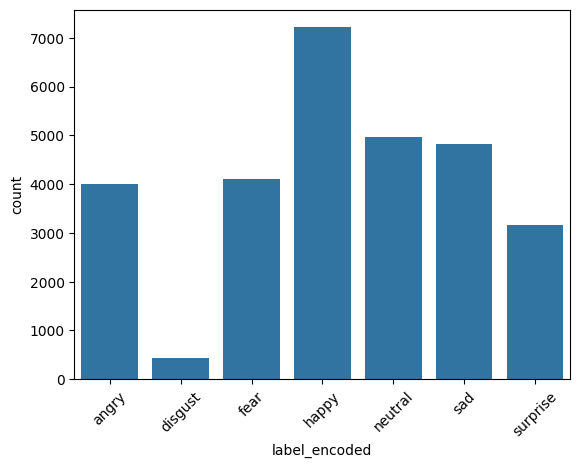

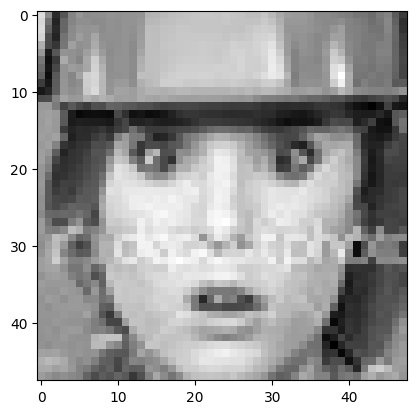

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
    return image_paths, labels

train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)

test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)

label_encoder = LabelEncoder()
train['label_encoded'] = label_encoder.fit_transform(train['label'])

# Plot class distribution
sns.countplot(data=train, x='label_encoded')
tick_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
plt.xticks(range(len(label_encoder.classes_)), tick_labels, rotation=45)
plt.show()

# Visualize a sample image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')
plt.show()

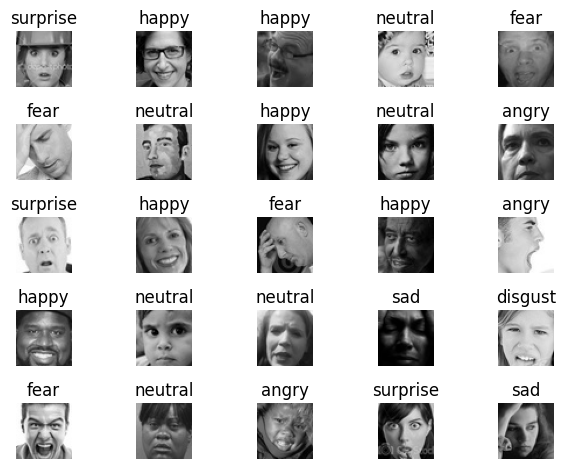

In [ ]:
files = train.iloc[0:25]

for index, row in files.iterrows():
    plt.subplot(5, 5, index + 1)
    img = load_img(row['image'])
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

Feature extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
train_features = extract_features(train['image'].iloc[:5000])
with open('train_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)

print("Train features saved successfully.")


  0%|          | 0/5000 [00:00<?, ?it/s]

Train features saved successfully.


In [ ]:
test_features = extract_features(test['image'].iloc[:5000])
with open('test_features.pkl', 'wb') as f:
    pickle.dump(test_features, f)

print("Test features saved successfully.")

  0%|          | 0/5000 [00:00<?, ?it/s]

Test features saved successfully.


In [ ]:
# In the cell where you define and prepare your training and testing data (likely ipython-input-9-7ca330a34abe)
x_train = train_features / 255.0
x_test = test_features / 255.0

# Ensure y_train and y_test are created using the same number of samples as x_train and x_test
y_train_labels = train['label'].iloc[:5000]  # Take only the first 5000 labels
y_test_labels = test['label'].iloc[:5000]  # Take only the first 5000 labels (adjust if necessary based on test_features size)

y_train_encoded = label_encoder.transform(y_train_labels)
y_test_encoded = label_encoder.transform(y_test_labels)

output_class = len(label_encoder.classes_)

y_train = to_categorical(y_train_encoded, num_classes=output_class)
y_test = to_categorical(y_test_encoded, num_classes=output_class)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (5000, 48, 48, 1)
y_train shape: (5000, 7)
x_test shape: (5000, 48, 48, 1)
y_test shape: (5000, 7)


In [ ]:
input_shape = (48, 48, 1)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model architecture
print("\nModel Architecture:")
model.summary()



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,804,551 (22.14 MB)

 Trainable params: 5,804,551 (22.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 229s 23s/step - accuracy: 0.1735 - loss: 1.9438 - val_accuracy: 0.3548 - val_loss: 1.8274
Epoch 2/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 256s 23s/step - accuracy: 0.2384 - loss: 1.8519 - val_accuracy: 0.3548 - val_loss: 1.8087
Epoch 3/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 262s 23s/step - accuracy: 0.2493 - loss: 1.8291 - val_accuracy: 0.3548 - val_loss: 1.8480
Epoch 4/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 262s 23s/step - accuracy: 0.2499 - loss: 1.8242 - val_accuracy: 0.3548 - val_loss: 1.8172
Epoch 5/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 262s 23s/step - accuracy: 0.2569 - loss: 1.8141 - val_accuracy: 0.3548 - val_loss: 1.8120
Epoch 6/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 219s 22s/step - accuracy: 0.2511 - loss: 1.8169 - val_accuracy: 0.3548 - val_loss: 1.8134
Epoch 7/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 296s 26s/step - accuracy: 0.2557 - loss: 1.8111 - val_accuracy: 0.3548 - val_loss: 1.8095
Epoch 8/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 228s 22s/step - accuracy: 0.2540 - loss: 1.7939 - val_accuracy: 0.

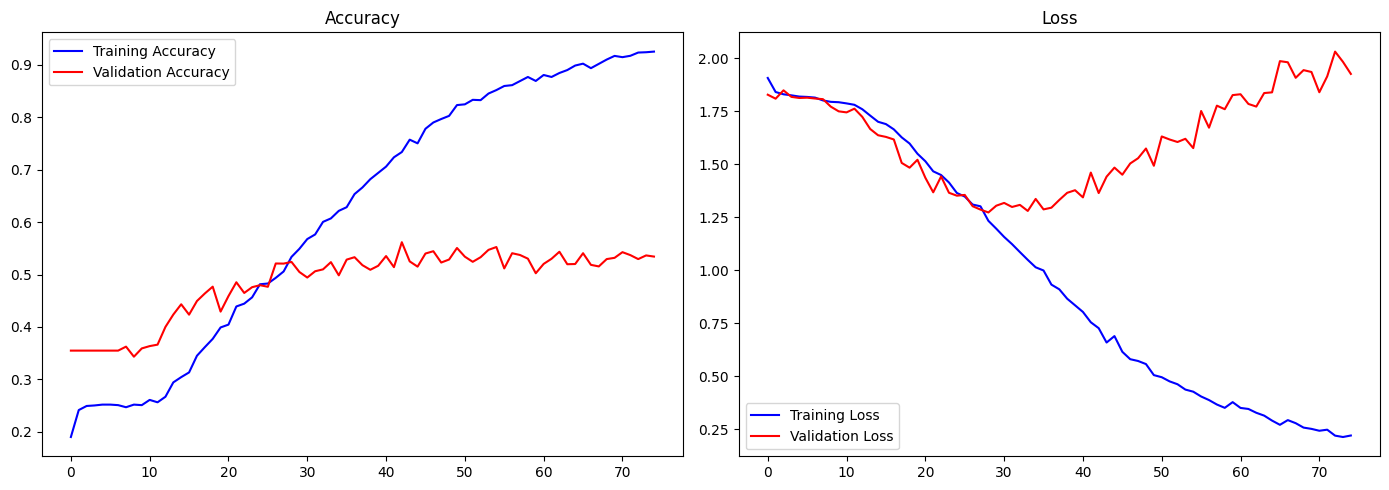

In [ ]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=512,
    epochs=75,  # Adjust as needed
    validation_data=(x_test, y_test),
    verbose=1
)

# Display epoch-wise metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print("\nTraining Summary:")
for epoch in range(len(acc)):
    print(f"Epoch {epoch + 1}:")
    print(f"  Training Accuracy: {acc[epoch]:.4f}")
    print(f"  Validation Accuracy: {val_acc[epoch]:.4f}")
    print(f"  Training Loss: {loss[epoch]:.4f}")
    print(f"  Validation Loss: {val_loss[epoch]:.4f}")
    print()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print final results
print("\nFinal Results:")
print(f"  Training Accuracy: {acc[-1]:.4f}")
print(f"  Validation Accuracy: {val_acc[-1]:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Training Loss: {loss[-1]:.4f}")
print(f"  Validation Loss: {val_loss[-1]:.4f}")

# Plot metrics
epochs = range(len(acc))
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 53.42%


In [ ]:
# Save the trained model
os.makedirs('/content/drive/MyDrive/Trained_Models', exist_ok=True)
model.save(model_dir)
print(f"Model saved at: {model_dir}")

Model saved at: Trained Models/model.h5


In [ ]:
!pip install gradio --quiet

import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(model_dir)

# Define the prediction function
def predict_expression(image):
    img = load_img(image, target_size=(48, 48), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape(1, 48, 48, 1) / 255.0
    prediction = model.predict(img_array)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Create and launch the Gradio interface
interface = gr.Interface(
    fn=predict_expression,
    inputs=gr.Image(type="filepath", label="Upload an Image"),
    outputs=gr.Text(label="Predicted Expression"),
    title="Facial Expression Recognition",
    description="Upload a grayscale image (48x48 pixels) to predict the facial expression."
)

interface.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7f2dc42db1fbcc46c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
